Importing the required libraries and packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils import resample
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Loading data
df = pd.read_csv("product_reviews.csv", encoding='unicode_escape')
# Display the last 10 rows of the DataFrame to verify the data
df.tail(10)

,ProductName,Price,Rate,Review,Summary
189864,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,4,Pretty good,Good ð
189865,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Worth every penny,Very nice cream
189866,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Great product,It's a nice product...thanks very much to Flip...
189867,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Best in the market!,Thanks â¤ï¸
189868,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Terrific,Good
189869,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Terrific,Thanks
189870,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Terrific,Good
189871,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Just wow!,Super
189872,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,4,Worth the money,Good
189873,,NaN,NaN,NaN,NaN


In [4]:
#Checking the size of our data
print("Number of rows:", df.shape[0])  # Number of rows
print("Number of columns:", df.shape[1])  # Number of columns

Number of rows: 189874
Number of columns: 5


# Data cleaning and preprocessing
- Revoming data entries with null values

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189857 entries, 0 to 189872
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductName  189857 non-null  object
 1   Price        189857 non-null  object
 2   Rate         189857 non-null  object
 3   Review       189857 non-null  object
 4   Summary      189857 non-null  object
dtypes: object(5)
memory usage: 8.7+ MB


- Since Rate column has some text data. I will remove colunm with text and keep only rating values which are integer for further data cleaning

In [6]:
df=df[(df['Rate'] == '5') | (df['Rate'] == '4') | (df['Rate'] == '3') | (df['Rate'] == '2') | (df['Rate'] == '1') ]
df['Rate'].value_counts()

Rate
5    108684
4     39649
1     19607
3     15680
2      6233
Name: count, dtype: int64

- pre-processing text columns to removing noise and drop Price Column

In [7]:
# This function will remove non-alphanumeric characters and then reducing multiple whitespaces to a single whitespace
def preprocess(row):
    if isinstance(row, str):
        row = re.sub('[^a-zA-Z0-9]', ' ', row)
        row = re.sub('\s+', ' ', row)
        return row
    else:
        return str(row)

In [8]:
# Apply the preprocessing function to the specified columns
df['Review']=df['Review'].apply(lambda x: preprocess(x))
df['Summary']=df['Summary'].apply(lambda x: preprocess(x))
df['ProductName']=df['ProductName'].apply(lambda x: preprocess(x))
# Dropping the 'Price' column
df.drop(['Price'],axis=1,inplace=True)

# Feature Engineering:
- Assigning sentiment values based on ratings (positive(5,4), neutral(3) and Negative(2,1) 

In [9]:
sentiment_map={'5':'positive','4':'positive','2':'negative','1':'negative', '3':'neutral'}
df['Sentiment']=df['Rate'].map(sentiment_map)

- Plotting the sentiment distribution

<Axes: xlabel='Sentiment', ylabel='count'>

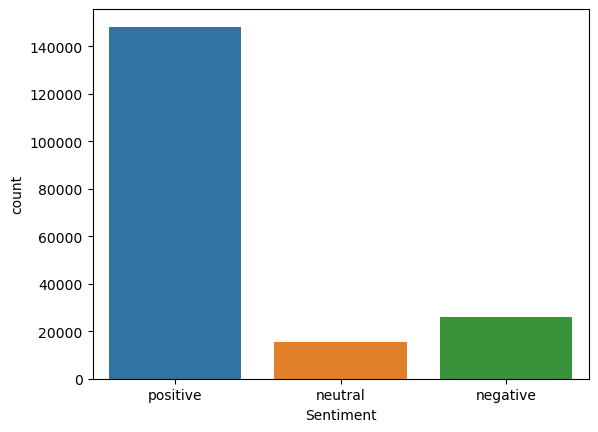

In [10]:
sns.countplot(df, x='Sentiment')

- Since the postive reviews takes the largest portion of data I need to down sample the positive class   and balance the data

In [11]:
# Extracting reviews based on sentiment
bad_reviews = df[df['Sentiment']=='negative']
nue_reviews=df[df['Sentiment'] == 'neutral']
good_reviews=df[df['Sentiment']=='positive']
# Concatenate the reviews into strings
good_reviews_text=' '.join (good_reviews['Summary'].to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews['Summary'].to_numpy().tolist())
nue_reviews_text=" ".join(nue_reviews['Summary'].to_numpy().tolist())

In [12]:
# Downsample the "good_reviews" DataFrame
good_reviews_down_sample = resample(good_reviews, n_samples=len(bad_reviews), replace=False)
# Join the downsampled reviews into a single string
good_reviews_down_sample_text = " ".join(good_reviews_down_sample['Summary'].to_numpy().tolist())


#  Data Visualization
- plotting word cloud to understand important words in each sentiment classes

In [13]:
# Function to generate Word Cloud
def gen_wc(txt):
    stopwords = set(STOPWORDS) 
    # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
    wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

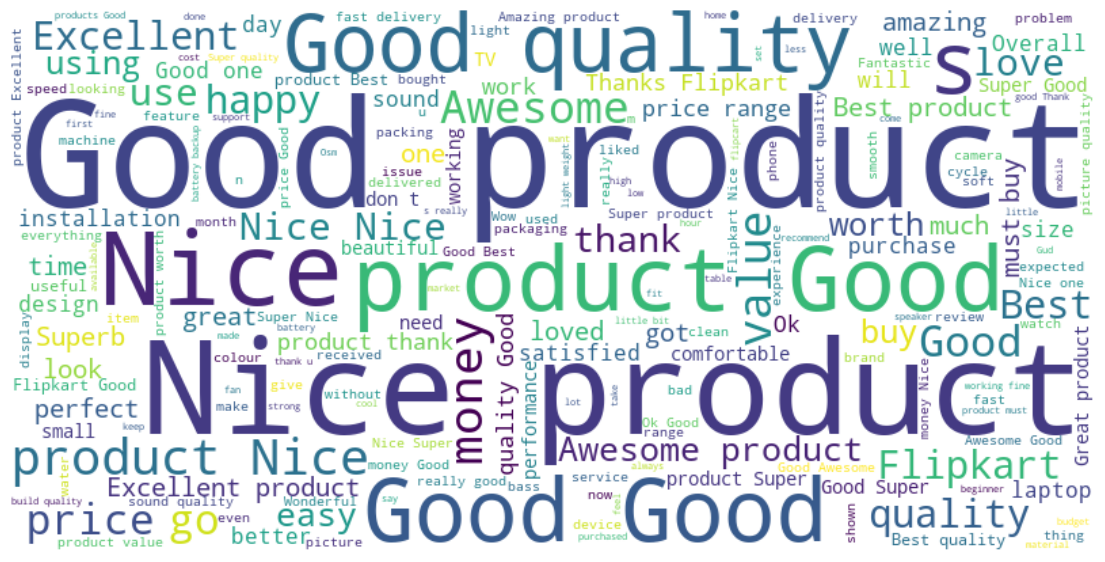

In [14]:
# Wordcloud for sentiments with positive class before downsampling
gen_wc(good_reviews_text)

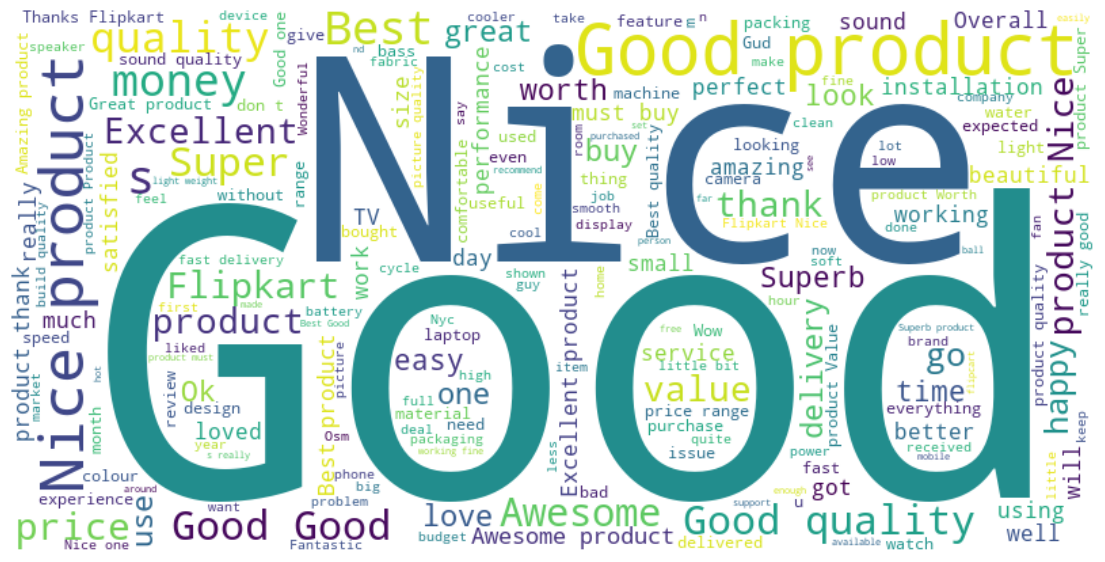

In [15]:
# Wordcloud for sentiments with positive class after downsampling
gen_wc(good_reviews_down_sample_text)

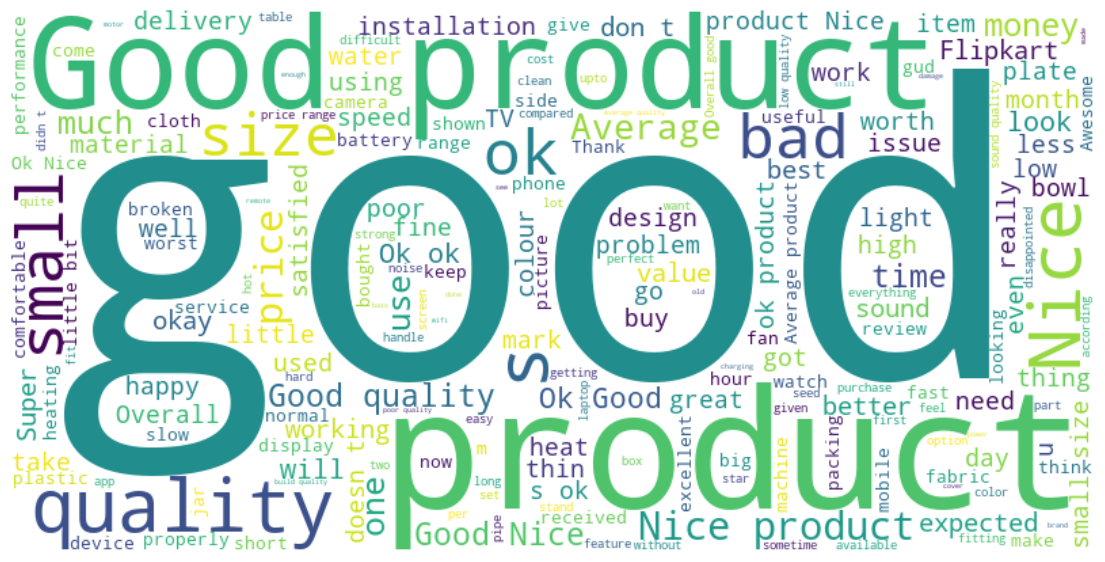

In [16]:
# Wordcloud for sentiments with Neutral class
gen_wc(nue_reviews_text)

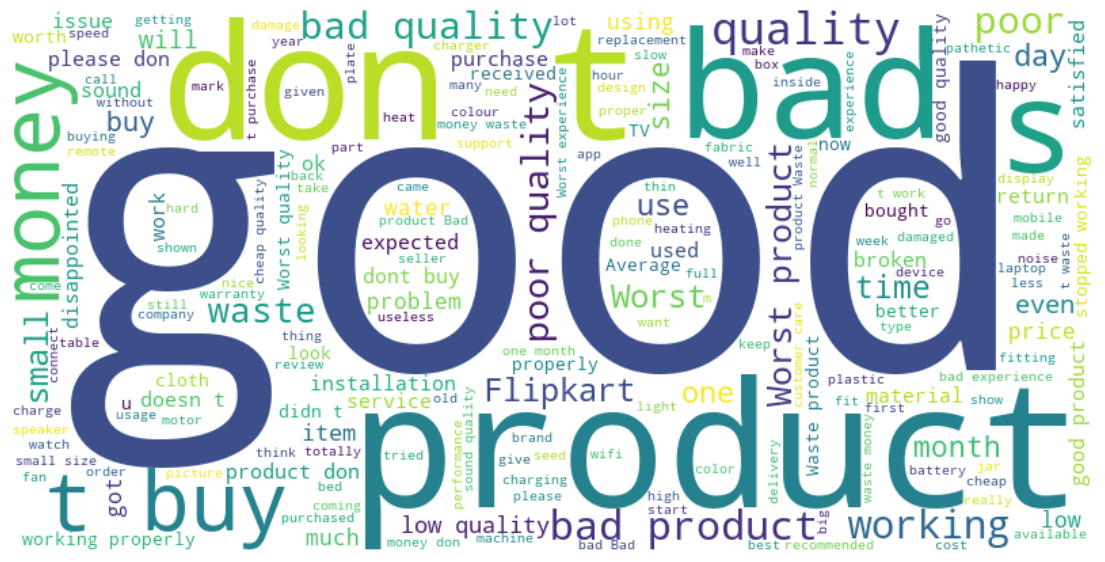

In [17]:
# Wordcloud for sentiments with Negative class
gen_wc(bad_reviews_text)

- Further Data Preprocessing

In [18]:
balanced_data=pd.concat([bad_reviews,nue_reviews,good_reviews_down_sample],axis=0)
balanced_data['Sentiment'].value_counts()

Sentiment
negative    25840
positive    25840
neutral     15680
Name: count, dtype: int64

- plotting count graph after balancing the data

<Axes: xlabel='Rate', ylabel='count'>

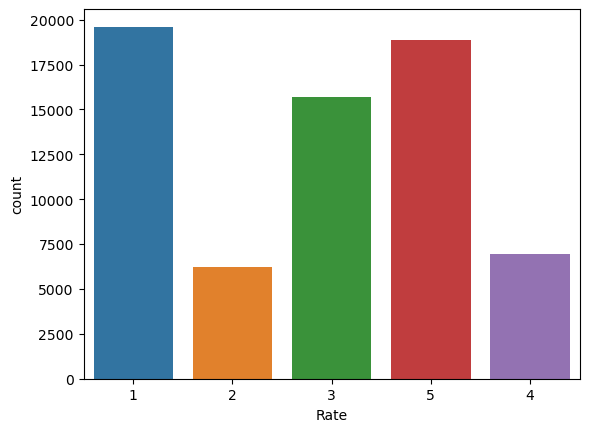

In [19]:
sns.countplot(balanced_data, x='Rate')

<Axes: xlabel='Sentiment', ylabel='count'>

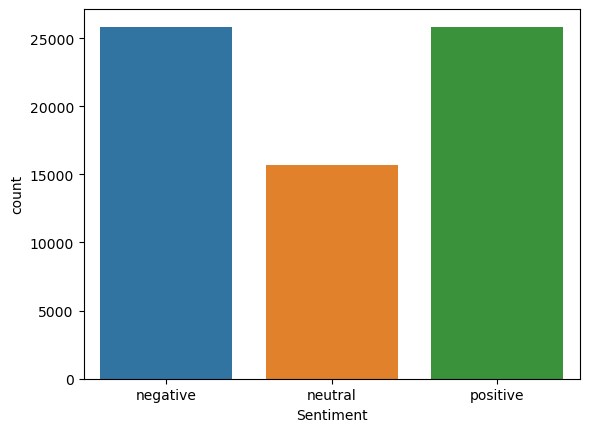

In [20]:
sns.countplot(balanced_data, x='Sentiment')

# Data Encoding and Splitting
- Encoding the lables into integers and split the data into train and test

In [21]:
from sklearn.preprocessing import LabelEncoder
label_enc=LabelEncoder()
balanced_data['Sentiment']=label_enc.fit_transform(balanced_data['Sentiment'])
balanced_data['comments']=balanced_data['Review'] +" " + balanced_data['Summary']

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(balanced_data['comments'], balanced_data['Sentiment'], test_size=0.3)

- Count Vectorizer and TF-IDF (Term Frequency-Inverse Document Frequency)
 -are techniques used for converting text data into numerical representations that machine learning models can understand

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Fitting TF-IDF
tfidf=TfidfVectorizer()
tfidf.fit(balanced_data['comments'])

tf_x_train=tfidf.transform(x_train)
tf_x_test=tfidf.transform(x_test)


In [24]:
#Fitting the CountVectorizer
cnvec = CountVectorizer()
cnvec.fit(balanced_data['comments'])
#Transforming the Training and Test Data
cn_x_train = cnvec.transform(x_train)
cn_x_test = cnvec.transform(x_test)


- Building pipeline

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone
def model(clf, x_train_tf, x_test_tf, y_train, y_test, x_train_cv, x_test_cv):
    #Cloning the classfier
    clf1=clone(clf)
    #Fit and Predict with TF-IDF
    clf.fit(x_train_tf, y_train)
    y_pred_tf=clf.predict(x_test_tf)
    #Print Classification Report and Confusion Matrix for TF-IDF
    print(f"The classification report for {clf} for tfidf embedding is \n\n {classification_report(y_test,y_pred_tf)}")
    print (f"The confusion matrix for {clf} model for tfidf embedding is \n\n {confusion_matrix(y_test, y_pred_tf)} \n\n ")
    
    #Fit and Predict with Count Vectorizer
    clf1.fit(x_train_cv, y_train)
    y_pred_cv=clf1.predict(x_test_cv)
    #Print Classification Report and Confusion Matrix for Count Vectorizer
    print(f"Classification report for {clf} model for Count Vect is \n\n {classification_report(y_test,y_pred_cv)}")
    print (f"Confusion matrix for {clf} model for Count Vec is \n\n {confusion_matrix(y_test, y_pred_cv)}")

In [26]:
from sklearn.naive_bayes import MultinomialNB
# Initialize the MultinomialNB classifier
mnb=MultinomialNB()
model(mnb,tf_x_train, tf_x_test, y_train, y_test, cn_x_train, cn_x_test)

The classification report for MultinomialNB() for tfidf embedding is 

               precision    recall  f1-score   support

           0       0.88      0.97      0.92      7643
           1       0.93      0.62      0.74      4809
           2       0.86      0.95      0.90      7756

    accuracy                           0.88     20208
   macro avg       0.89      0.85      0.86     20208
weighted avg       0.88      0.88      0.87     20208

The confusion matrix for MultinomialNB() model for tfidf embedding is 

 [[7439  108   96]
 [ 755 2974 1080]
 [ 268  121 7367]] 

 
Classification report for MultinomialNB() model for Count Vect is 

               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7643
           1       0.84      0.73      0.78      4809
           2       0.87      0.95      0.91      7756

    accuracy                           0.89     20208
   macro avg       0.89      0.87      0.88     20208
weighted avg       0

In [27]:
from sklearn.svm import SVC
# Initialize the SVM classifier
sv=SVC()
model(sv,tf_x_train, tf_x_test, y_train, y_test, cn_x_train, cn_x_test)

The classification report for SVC() for tfidf embedding is 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7643
           1       0.92      0.83      0.87      4809
           2       0.93      0.96      0.94      7756

    accuracy                           0.94     20208
   macro avg       0.93      0.92      0.93     20208
weighted avg       0.94      0.94      0.94     20208

The confusion matrix for SVC() model for tfidf embedding is 

 [[7476  109   58]
 [ 275 3993  541]
 [  64  226 7466]] 

 
Classification report for SVC() model for Count Vect is 

               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7643
           1       0.95      0.78      0.85      4809
           2       0.93      0.94      0.93      7756

    accuracy                           0.92     20208
   macro avg       0.92      0.90      0.91     20208
weighted avg       0.92      0.92      0.92     20

In [28]:
# Function to predict sentiment based on user input
def predict_sentiment(user_review):
    # Preprocess the input review
    user_review = preprocess(user_review)
    # Vectorize the user review using the TF-IDF vectorizer
    user_review_tfidf = tfidf.transform([user_review])
    # Predict using the trained model
    prediction = sv.predict(user_review_tfidf)
    # Map predicted sentiment to labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment_label = sentiment_labels[prediction[0]]
    return predicted_sentiment_label

In [29]:
import random

# Function to predict rating based on sentiment
def map_sentiment_to_rating(sentiment):
    if sentiment == 'Negative':
        # Assign a random rating between 1 and 2 for negative sentiment
        return random.uniform(1, 2)
    elif sentiment == 'Neutral':
        return 3  # Assign a fixed rating of 3 for neutral sentiment
    elif sentiment == 'Positive':
        # Assign a random rating between 4 and 5 for positive sentiment
        return random.uniform(4, 5)
    else:
        return None


In [30]:
 #User enters a review
user_review = input("Enter your review: ")
# Predict sentiment
predicted_sentiment = predict_sentiment(user_review)

# Map predicted sentiment to rating
predicted_rating = map_sentiment_to_rating(predicted_sentiment)

# Display the predicted sentiment and rating
print(f'Predicted sentiment: {predicted_sentiment}')
print(f'Predicted rating: {predicted_rating}')

Predicted sentiment: Neutral
Predicted rating: 3


# Saving the trained model for futere use

In [31]:
import joblib

# Save the trained model and TF-IDF vectorizer
# Replace 'path/to/sentiment_model.joblib' and 'path/to/tfidf_vectorizer.joblib' with the desired paths.
joblib.dump(sv, './sentiment_model.joblib')
joblib.dump(tfidf, './tfidf_vectorizer.joblib')


['./tfidf_vectorizer.joblib']